In [1]:
from fastai.vision.all import *
from fastai.callback.tensorboard import TensorBoardCallback
import pandas as pd
import os
import optuna
from IPython.utils.io import capture_output
from tqdm.notebook import tqdm
from PIL import Image, ImageOps

# project library - datasets and dataloaders
from bus_data import *


In [2]:
code_path = os.getcwd()

model_dir = "unet_models"
trials_dir = "unet_trials"
log_dir = "unet_logs"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(trials_dir):
    os.makedirs(trials_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

if os.uname()[1] == "media":
    # Florin's gaming PC
    data_volume = "/home/florin/data"
else:
    # Google Colab
    from google.colab import drive

    gdrive_path = "/content/gdrive"
    drive.mount(gdrive_path, force_remount=False)
    data_volume = gdrive_path + "/MyDrive"

input_image_size = 224
cnn_arch = resnet34


# Create dataloader

In [3]:
train_df = pd.DataFrame(
    {
        "dataset": [],
        "image": [],
        "mask": [],
        "tumor": [],
    }
)

train_df = pd.concat([train_df, busis_dataset_make(data_volume)], ignore_index=True)
train_df = pd.concat([train_df, bus_dataset_b_make(data_volume)], ignore_index=True)
train_df = pd.concat(
    [train_df, dataset_busi_with_gt_make(data_volume)], ignore_index=True
)
train_df = pd.concat([train_df, mayo_dataset_make(data_volume)], ignore_index=True)
train_df["dataset_tumor"] = train_df["dataset"] + "_" + train_df["tumor"]
train_df


,dataset,image,mask,tumor,dataset_tumor
0,BUSIS,/home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case104.png,[/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case104_GT.bmp],benign,BUSIS_benign
1,BUSIS,/home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case325.png,[/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case325_GT.bmp],malignant,BUSIS_malignant
2,BUSIS,/home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case425.png,[/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case425_GT.bmp],malignant,BUSIS_malignant
3,BUSIS,/home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case339.png,[/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case339_GT.bmp],benign,BUSIS_benign
4,BUSIS,/home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case216.png,[/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case216_GT.bmp],malignant,BUSIS_malignant
...,...,...,...,...,...
1789,Mayo,/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/761858134_long.png,[/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/761858134_long_mask.png],benign,Mayo_benign
1790,Mayo,/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/679670173_long.png,[/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/679670173_long_mask.png],malignant,Mayo_malignant
1791,Mayo,/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/805361134_tran.png,[/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/805361134_tran_mask.png],benign,Mayo_benign
1792,Mayo,/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/451084310_dopp.png,[/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/451084310_dopp_mask.png],benign,Mayo_benign


In [4]:
# mapping classes to/from pixel values
id2label, label2id, num_labels = labels_ids_bus()


In [5]:
def bus_image_make(row):
    """
    Receives a Pandas row. Gets an image path from the "image" column.
    Makes sure all images are 8 bits per color channel.
    (There may be multiple color channels.)
    Returns a PILImage.create() image.
    """
    f = ColReader("image")
    image_array = np.asarray(PILImage.create(f(row)))
    return PILImage.create(image_array)


def bus_mask_make(row):
    """
    Is called by DataBlock(getters=).
    Takes a list of paths to mask files from a Pandas column.
    Makes sure all masks are 8 bits per pixel.
    If there are multiple masks, merges them.
    Returns a PILMask.create() mask image.
    """
    all_images = [np.asarray(PILMask.create(x), dtype=np.uint8) for x in row["mask"]]
    image_stack = np.stack(all_images)
    if row["tumor"] == "benign":
        image_stack = np.clip(image_stack, 0, label2id["benign"])
    elif row["tumor"] == "malignant":
        image_stack = np.clip(image_stack, 0, label2id["malignant"])
    image_union = np.amax(image_stack, axis=0)
    return PILMask.create(image_union)


class BusTrainCustomTransform(DisplayedTransform):
    """
    Chain of custom transforms for item_tfms.
    Used by item_tfms in training.
    """

    def __init__(self, resize_dim):
        # width, height
        self.resize_dim = resize_dim

    def encodes(self, x):
        return x.resize(size=self.resize_dim)


bus_datablock = DataBlock(
    blocks=(ImageBlock, MaskBlock),
    getters=[bus_image_make, bus_mask_make],
    splitter=TrainTestSplitter(
        stratify=train_df["dataset_tumor"].to_list(), random_state=42
    ),
    item_tfms=[
        BusTrainCustomTransform(resize_dim=(input_image_size, input_image_size))
    ],
    batch_tfms=aug_transforms(pad_mode="reflection", max_lighting=0.2, max_rotate=30.0),
)

bus_dataloader = bus_datablock.dataloaders(train_df, bs=8)


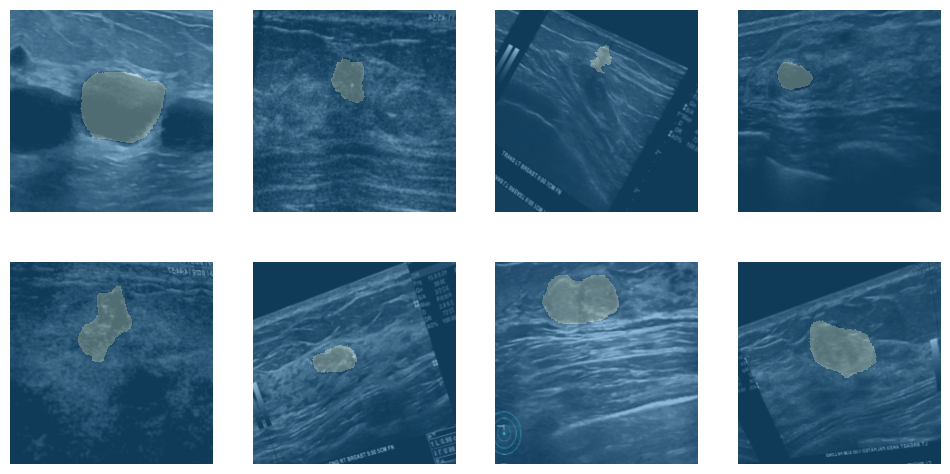

In [6]:
bus_dataloader.show_batch()


# Create training function

In [7]:
class IOUMulti(Metric):
    """
    IoU metric for semantic (multiclass) segmentation.
    Works with fast.ai models.

    The used_classes parameter takes the list of int8 classes
    that are actually used by the model. IoU is only computed
    for those classes. All other classes are ignored.
    Example: IOUMulti(axis=1, used_classes=[1, 2])

    input: predictions and ground truth targets
    output: multiclass IoU metric
    """

    def __init__(self, axis=1, used_classes=[]):
        self.axis = axis
        self.used_classes = used_classes

    def reset(self):
        self.inter, self.union = {}, {}

    def accumulate(self, learn):
        pred, targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        # for c in range(learn.pred.shape[self.axis]):
        for c in self.used_classes:
            p = torch.where(pred == c, 1, 0)
            t = torch.where(targ == c, 1, 0)
            c_inter = (p * t).float().sum().item()
            c_union = (p + t).float().sum().item()
            if c in self.inter:
                self.inter[c] += c_inter
                self.union[c] += c_union
            else:
                self.inter[c] = c_inter
                self.union[c] = c_union

    @property
    def value(self):
        binary_iou_scores = np.array([])
        for c in self.inter:
            binary_iou_scores = np.append(
                binary_iou_scores,
                self.inter[c] / (self.union[c] - self.inter[c])
                if self.union[c] > 0
                else np.nan,
            )
        return np.nanmean(binary_iou_scores)


def train_model(
    trial_number,
    base_lr,
    lr_mult,
    freeze_epochs,
    max_epochs,
):
    trial_number_pad = str(trial_number).zfill(10)

    bus_learner = unet_learner(
        bus_dataloader,
        resnet34,
        n_out=256,
        path=code_path,
        model_dir=model_dir,
        loss_func=CrossEntropyLossFlat(axis=1),
        metrics=[
            IOUMulti(axis=1, used_classes=[label2id["benign"], label2id["malignant"]])
        ],
    )
    if freeze_epochs == 0:
        bus_learner.save("model_" + trial_number_pad, with_opt=True)

    with bus_learner.no_bar():
        bus_learner.fine_tune(
            epochs=max_epochs,
            base_lr=base_lr,
            lr_mult=lr_mult,
            freeze_epochs=freeze_epochs,
            cbs=[
                SaveModelCallback(
                    monitor="iou_multi",
                    comp=np.greater,
                    fname="model_" + trial_number_pad,
                    with_opt=True,
                ),
                TensorBoardCallback(log_dir=log_dir + "/trial_" + trial_number_pad),
                EarlyStoppingCallback(patience=10),
            ],
        )
        recorder_values = bus_learner.recorder.values
        best_metric = 0
        for v in recorder_values:
            # IoU is the third field in each record
            if best_metric < v[2]:
                best_metric = v[2]
    print("")
    print(f"best metric: {best_metric}")
    
    del bus_learner
    torch.cuda.empty_cache()
    return best_metric


# Setup Optuna

In [8]:
def objective(trial):
    """
    input: Optuna trial
    output: best model performance metric

    The objective function for hyperparameter optimization.
    Used by study.optimize()
    Calls train_model() with the appropriate hyperparameter values.
    Captures and logs all output from train_model().
    """
    base_learning_rate = trial.suggest_float("base_learning_rate", 1e-6, 1e-1, log=True)
    learning_rate_multiplier = trial.suggest_float(
        "learning_rate_multiplier", 1e4, 1e8, log=True
    )
    freeze_epochs = trial.suggest_int("freeze_epochs", 0, 5)

    # define log file, log parameters
    trial_number_pad = str(trial.number).zfill(10)
    output_file_name = trials_dir + "/trial_" + trial_number_pad
    with open(output_file_name, "w") as cf:
        print(f"{trial.params}\n", file=cf)

    # main training step
    with capture_output(stdout=True, stderr=True, display=True) as captured:
        best_metric = train_model(
            trial_number=trial.number,
            base_lr=base_learning_rate,
            lr_mult=learning_rate_multiplier,
            freeze_epochs=freeze_epochs,
            max_epochs=100,
        )
    with open(output_file_name, "a") as cf:
        print(captured.stdout, file=cf)
        print(captured.stderr, file=cf)

    del captured
    return best_metric


# study definition
study = optuna.create_study(
    direction="maximize",
    study_name="train-all-semantic-resnet34-crossentropy-stopafter10-take1",
    storage="sqlite:///unet_optuna.db",
    load_if_exists=True,
)


[I 2022-12-07 22:48:36,262] Using an existing study with name 'train-all-semantic-resnet34-crossentropy-stopafter10-take1' instead of creating a new one.


In [9]:
study.optimize(objective, timeout=8*3600, show_progress_bar=True, gc_after_trial=True)
# study.optimize(objective, n_trials=1, show_progress_bar=True, gc_after_trial=True)


/home/florin/.local/lib/python3.10/site-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 00:00/

[I 2022-12-07 23:02:28,831] Trial 140 finished with value: 0.5860479039872122 and parameters: {'base_learning_rate': 0.0028932284557868482, 'learning_rate_multiplier': 15612.097580778938, 'freeze_epochs': 2}. Best is trial 134 with value: 0.64191324282781.
[I 2022-12-07 23:27:03,395] Trial 141 finished with value: 0.6047381164695875 and parameters: {'base_learning_rate': 0.001579915782482203, 'learning_rate_multiplier': 13468.663957674105, 'freeze_epochs': 2}. Best is trial 134 with value: 0.64191324282781.
[I 2022-12-07 23:38:18,499] Trial 142 finished with value: 0.5546668820349969 and parameters: {'base_learning_rate': 0.0016652279588775106, 'learning_rate_multiplier': 7195113.412629445, 'freeze_epochs': 2}. Best is trial 134 with value: 0.64191324282781.
[I 2022-12-07 23:50:06,328] Trial 143 finished with value: 0.5614513147169833 and parameters: {'base_learning_rate': 0.0022142014341547246, 'learning_rate_multiplier': 13723.913956512326, 'freeze_epochs': 2}. Best is trial 134 with

# Show fine-tuning results

In [10]:
best_trial = study.best_trial
print(f"Best Trial: {best_trial.number}")
print(f"Best Score: {best_trial.value}")
print(f"Best Params:")
for k, v in best_trial.params.items():
    print(f"\t{k}: {v}")


Best Trial: 134
Best Score: 0.64191324282781
Best Params:
	base_learning_rate: 0.0029488947256724285
	freeze_epochs: 2
	learning_rate_multiplier: 10066.93280361663


In [11]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.show()


In [12]:
for fig in [
    optuna.visualization.plot_param_importances(study),
    optuna.visualization.plot_optimization_history(study),
    optuna.visualization.plot_slice(study),
]:
    fig.update_layout(
        autosize=False,
        width=1000,
        height=360,
    )
    fig.show()


# Sample predictions on the validation dataset

/home/florin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/florin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.



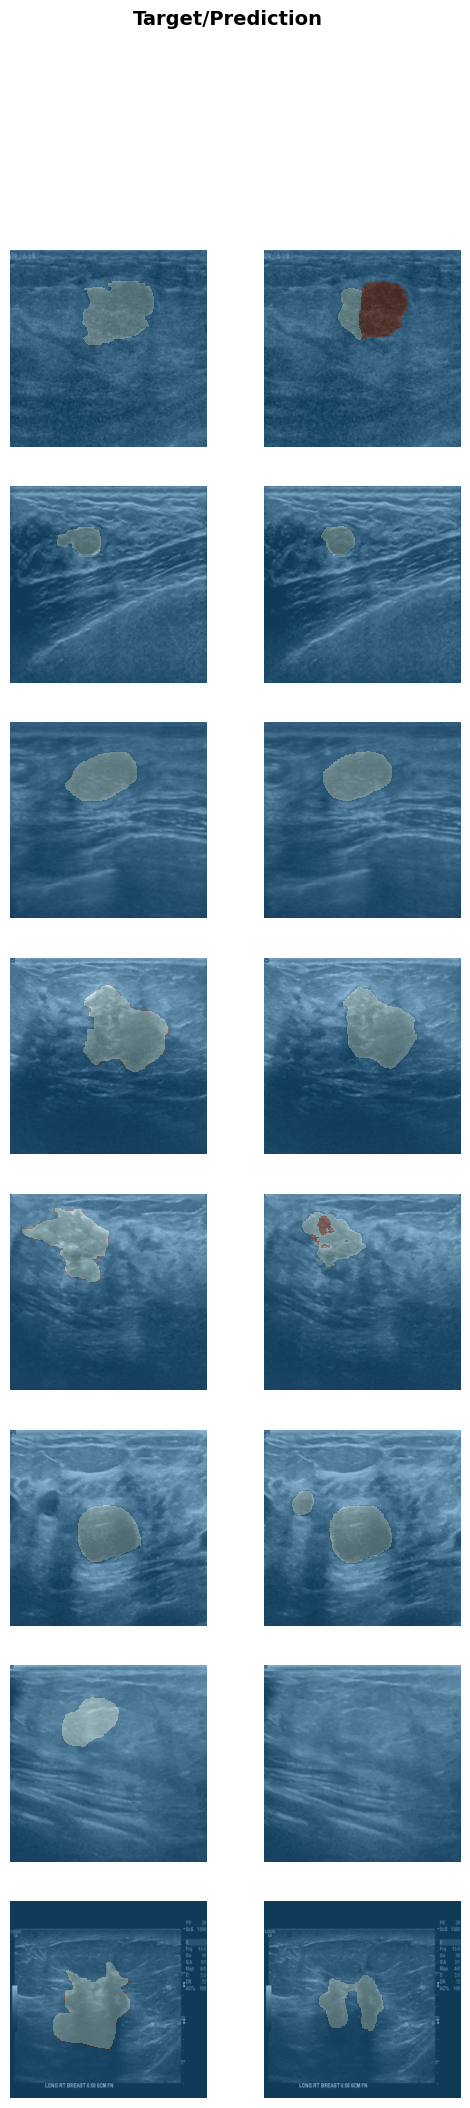

In [13]:
bus_learner = unet_learner(
    bus_dataloader,
    resnet34,
    n_out=256,
    path=code_path,
    model_dir=model_dir,
    loss_func=CrossEntropyLossFlat(axis=1),
)
bus_learner.load("model_" + str(study.trials[-1].number).zfill(10))

bus_learner.show_results()


In [14]:
buv_df = buv_dataset_make(data_volume)
buv_df


,dataset,class,video,image,str_index
0,BUV_dataset,benign,263b86b85a58f270,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/benign/263b86b85a58f270/000000.png,00000
1,BUV_dataset,benign,263b86b85a58f270,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/benign/263b86b85a58f270/000001.png,00001
2,BUV_dataset,benign,263b86b85a58f270,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/benign/263b86b85a58f270/000002.png,00002
3,BUV_dataset,benign,263b86b85a58f270,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/benign/263b86b85a58f270/000003.png,00003
4,BUV_dataset,benign,263b86b85a58f270,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/benign/263b86b85a58f270/000004.png,00004
...,...,...,...,...,...
25267,BUV_dataset,malignant,xf7f83b2a576016b,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/malignant/xf7f83b2a576016b/000186.png,25267
25268,BUV_dataset,malignant,xf7f83b2a576016b,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/malignant/xf7f83b2a576016b/000187.png,25268
25269,BUV_dataset,malignant,xf7f83b2a576016b,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/malignant/xf7f83b2a576016b/000188.png,25269
25270,BUV_dataset,malignant,xf7f83b2a576016b,/home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/malignant/xf7f83b2a576016b/000189.png,25270


In [15]:
def video_test(
    trial_number_pad,
    src_df,
    input_image_size,
    test_action,
    outdir,
):
    buv_datablock = DataBlock(
        blocks=(ImageBlock),
        getters=[ColReader("image")],
        item_tfms=[
            BusTrainCustomTransform(resize_dim=(input_image_size, input_image_size))
        ],
    )

    batch_size = 6
    buv_dataloader = buv_datablock.dataloaders(src_df, bs=batch_size)

    model_name = "model_" + trial_number_pad
    index_len = len(str(src_df.shape[0]))

    display_images = False
    if test_action == "display_images":
        display_images = True
    make_frames = False
    if test_action == "make_frames":
        make_frames = True

    buv_learner = unet_learner(
        buv_dataloader,
        resnet34,
        n_out=256,
        path=code_path,
        model_dir=model_dir,
        loss_func=CrossEntropyLossFlat(axis=1),
    )
    buv_learner.load(model_name)
    buv_learner.model.to("cuda")
    buv_learner.model.eval()

    pixel_count = pd.DataFrame(
        [[0, 0], [0, 0]], index=["benign", "malignant"], columns=["benign", "malignant"]
    )

    pred_dl = buv_learner.dls.test_dl(src_df["image"], bs=batch_size)
    max_i1 = math.ceil(src_df.shape[0] / batch_size) - 1
    for i, data in tqdm(
        enumerate(pred_dl, 0),
        total=math.ceil(src_df.shape[0] / batch_size),
        display=make_frames,
    ):
        # for i, data in enumerate(pred_dl, 0):
        if display_images and (i > 0 and i < max_i1):
            continue
        if display_images or make_frames:
            image_batch = [
                PILImage.create(im).resize(
                    (input_image_size, input_image_size),
                    resample=Image.Resampling.BILINEAR,
                )
                for im in src_df["image"][
                    i * batch_size : (i + 1) * batch_size
                ].to_list()
            ]
        image_class = src_df["class"][i * batch_size : (i + 1) * batch_size].to_list()
        image_video_id = src_df["video"][
            i * batch_size : (i + 1) * batch_size
        ].to_list()
        mask_preds = buv_learner.model(data[0])
        for j in range(mask_preds.shape[0]):
            image_index = j + i * batch_size
            image_index_str = src_df.loc[image_index, "str_index"]
            mask = np.array(mask_preds[j].argmax(dim=0).cpu()).astype("uint8")
            pixels_predicted_total = (mask != 0).sum()
            pixels_predicted_benign = (mask == 1).sum()
            pixels_predicted_malignant = (mask == 2).sum()
            if (
                pixels_predicted_total
                != pixels_predicted_benign + pixels_predicted_malignant
            ):
                print(
                    f"image id: {image_index_str} bad pixels: {pixels_predicted_total - pixels_predicted_benign - pixels_predicted_malignant}"
                )
            """
            assert (
                pixels_predicted_total
                == pixels_predicted_benign + pixels_predicted_malignant
            ), f"unexpected pixel value in mask {image_index}"
            """
            pixel_count.loc[image_class[j], "benign"] += pixels_predicted_benign
            pixel_count.loc[image_class[j], "malignant"] += pixels_predicted_malignant
            if display_images or make_frames:
                mask_img = Image.fromarray(mask)
            if display_images:
                mask_img_col = ImageOps.colorize(
                    mask_img,
                    black=(0, 0, 128),
                    white=(255, 127, 127),
                    mid=(127, 255, 127),
                    blackpoint=0,
                    midpoint=1,
                    whitepoint=2,
                )
                mask_img_blend = Image.blend(image_batch[j], mask_img_col, 0.2)
                final_frame = Image.new(
                    mode="RGB", size=(2 * input_image_size, input_image_size)
                )
                final_frame.paste(image_batch[j], (0, 0))
                final_frame.paste(mask_img_blend, (input_image_size, 0))
                print(image_index_str)
                display(final_frame)
            if make_frames:
                mask_img.save(outdir + "/f" + image_index_str + ".png", format="png")
    
    del buv_learner
    torch.cuda.empty_cache()

    pixel_ratio_benign = pixel_count.loc["benign", "benign"] / max(
        1, pixel_count.loc["benign", "benign"] + pixel_count.loc["benign", "malignant"]
    )
    pixel_ratio_malignant = pixel_count.loc["malignant", "malignant"] / max(
        1,
        pixel_count.loc["malignant", "benign"]
        + pixel_count.loc["malignant", "malignant"],
    )

    print()
    print(pixel_count)
    print()
    print(f"pixel ratio benign:    {pixel_ratio_benign}")
    print(f"pixel ratio malignant: {pixel_ratio_malignant}")

    return pixel_ratio_benign * pixel_ratio_malignant


video_test(
    str(best_trial.number).zfill(10),
    buv_df,
    input_image_size,
    test_action="display_images",
    outdir=None,
)


In [16]:
outdir_base = "frames"
outdir = outdir_base + "/masks_unet"
shutil.rmtree(outdir, ignore_errors=True)
try:
    os.mkdir(outdir_base)
except:
    pass
os.mkdir(outdir)
video_test(
    str(best_trial.number).zfill(10),
    buv_df,
    input_image_size,
    test_action="make_frames",
    outdir=outdir,
)
torch.cuda.empty_cache()


/home/florin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/florin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.



  0%|          | 0/4212 [00:00<?, ?it/s]


             benign  malignant
benign     11926350   22603024
malignant   8405027   80082012

pixel ratio benign:    0.3453972261414296
pixel ratio malignant: 0.9050140326200767
